In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sectionate
import xgcm
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.path as mpath

In [3]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
subplot_kws=dict(projection=ccrs.Robinson())
data_crs = ccrs.PlateCarree()

In [4]:
cmap = plt.get_cmap("Blues").copy()
cmap.set_bad((0.8, 0.8, 0.8))

def plot_sections(i, j, lons, lats, section_lons, section_lats, ds, projection=ccrs.Robinson(), vlim=[0, 5000]):
    
    fig, axes = plt.subplots(1, 2, figsize=[16,6], subplot_kw={'projection':projection})
    ax = axes[0]
    ds['deptho'].plot(x='geolon', y='geolat', ax=ax, transform=data_crs, cmap=plt.get_cmap("Blues"), vmin=vlim[0], vmax=vlim[1])
    ax.plot(lons, lats, 'k.-', transform=ccrs.Geodetic(), markersize=1.5, lw=0.5)
    ax.plot(section_lons, section_lats, "C3x", transform=data_crs, markersize=6., mew=3., alpha=0.85, label="Points of target section")
    ax.plot([60,60], [-75, 90], "w--", alpha=0.75, lw=1.75, transform=ccrs.Geodetic(), label="nominal ds boundary")
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    ax.set_title("With respect to geographic coordinates")
    ax.legend(loc="upper right", fontsize=12, labelspacing=0.12)
    ax.gridlines(alpha=0.2)
    ax.set_extent([-180, 180., -80, 80], ccrs.PlateCarree())
        
    if projection==ccrs.SouthPolarStereo():
        ax.set_extent([0, 360., -90, -40], ccrs.PlateCarree())

        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)
        
    elif projection==ccrs.NorthPolarStereo():
        ax.set_extent([0, 360., 50, 90], ccrs.PlateCarree())

        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        ax.set_boundary(circle, transform=ax.transAxes)

    ax = axes[1]
    ax = plt.subplot(1,2,2)
    pc = ax.pcolormesh(ds['deptho'].values, cmap=cmap, vmin=vlim[0], vmax=vlim[1])
    ax.plot(i, j, 'k.', markersize=1.5)
    ax.set_title("With respect to model indices (i,j)");
    plt.colorbar(pc, ax=ax)
    plt.tight_layout()
    
    return fig, axes

# Testing the limits of `sectionate` with edge cases

## 0. Load the model grid

In [5]:
from example_dataset_grids import load_CM4p25
ds, grid = load_CM4p25()

## 1.  A section that crosses the periodic `X` boundary

In [6]:
section_lons=[50, 70]
section_lats=[-55, -35]

section_lons[0] < ds['geolon_c'].max().values < section_lons[1]

True

### Desired behavior with `periodic=["X"]` (new default)

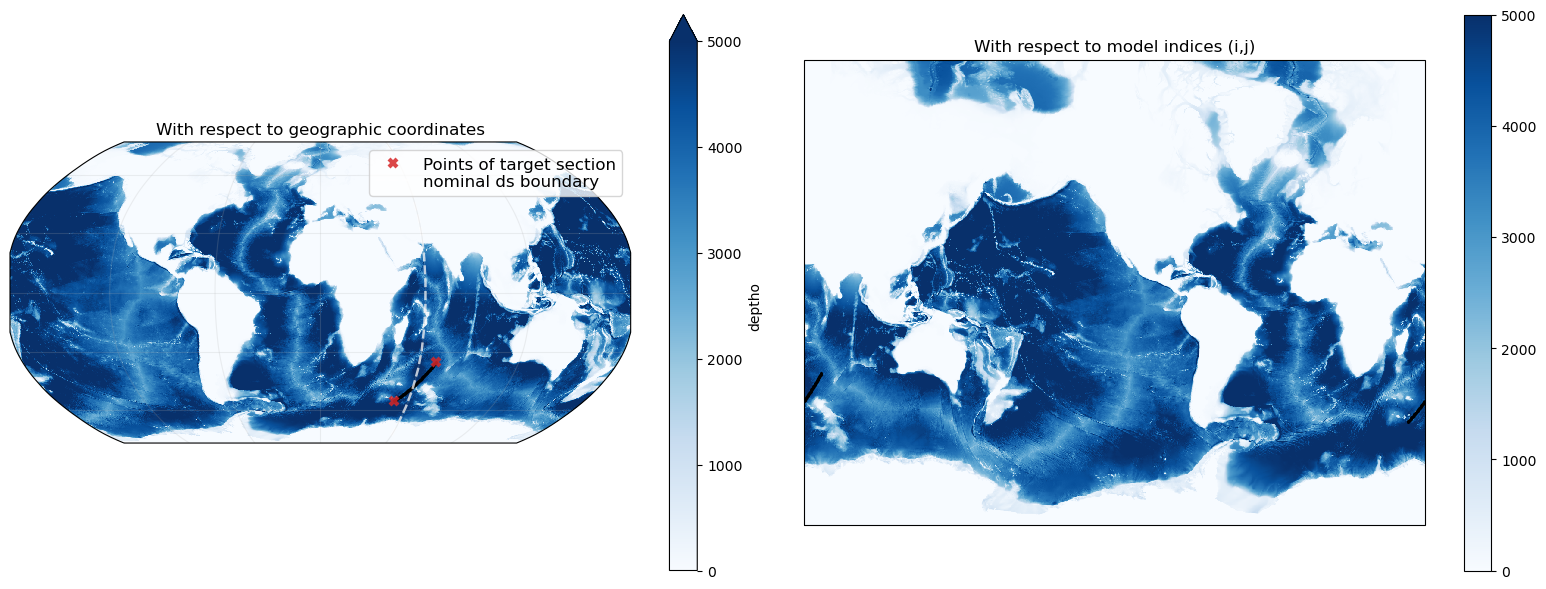

In [7]:
i, j, lons, lats = sectionate.create_section_composite(
    grid._ds['geolon_c'],
    grid._ds['geolat_c'],
    section_lons,
    section_lats,
    sectionate.check_symmetric(grid),
    periodic=["X"],
    topology="MOM-tripolar"
)

plot_sections(i, j, lons, lats, section_lons, section_lats, ds);

The `grid_section` function uses the `xgcm.Grid` instance to pass the correct arguments for `symmetric` and `periodic` to `create_section_composite`.

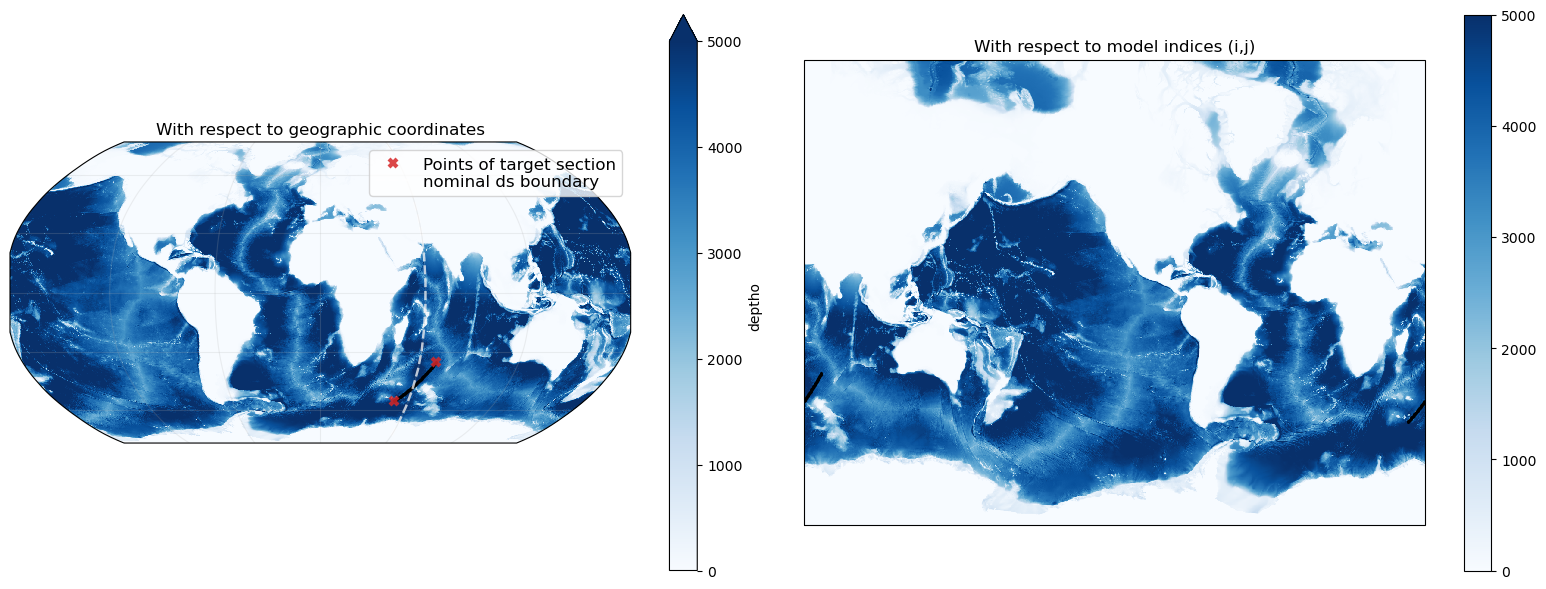

In [8]:
i, j, lons, lats = sectionate.grid_section(
    grid,
    section_lons,
    section_lats,
    topology="MOM-tripolar"
)

plot_sections(i, j, lons, lats, section_lons, section_lats, ds);

## 2.  Zonally-periodic sections

### Sectionate requires intermediate points to disambiguate zonal sections longer than 180º

Consider the case below where we aim to make a zonally-circumpolar section that passes through Drake Passage at 60ºS.

In [9]:
lat = -57.5

##### Incorrect use: no intermediate points $\rightarrow$ no section required to connect consecutive points

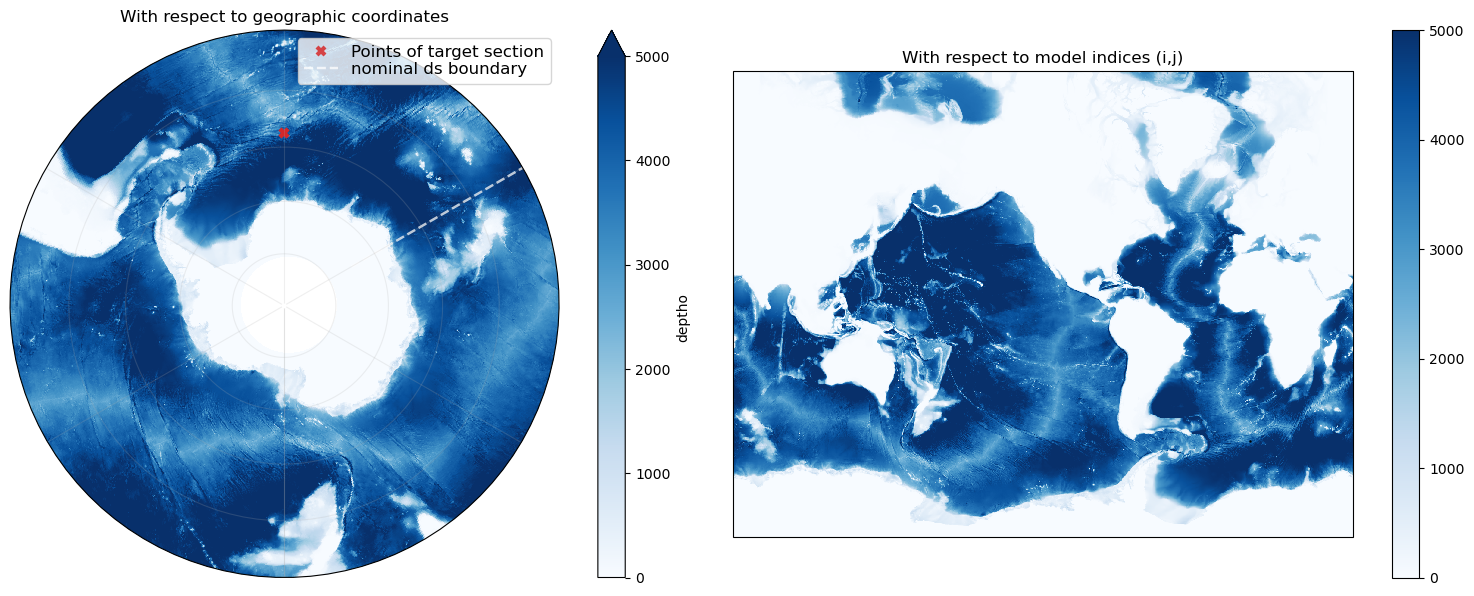

In [10]:
section_lons=[0, 360]
section_lats=[lat]*len(section_lons)

i, j, lons, lats = sectionate.grid_section(
    grid,
    section_lons,
    section_lats,
    topology="MOM-tripolar"
)
plot_sections(i, j, lons, lats, section_lons, section_lats, ds, projection=ccrs.SouthPolarStereo());

##### Incorrect use: intermediate points more than 180º apart $\rightarrow$ shortest subsections do not cirumnavigate (and just go out and back)

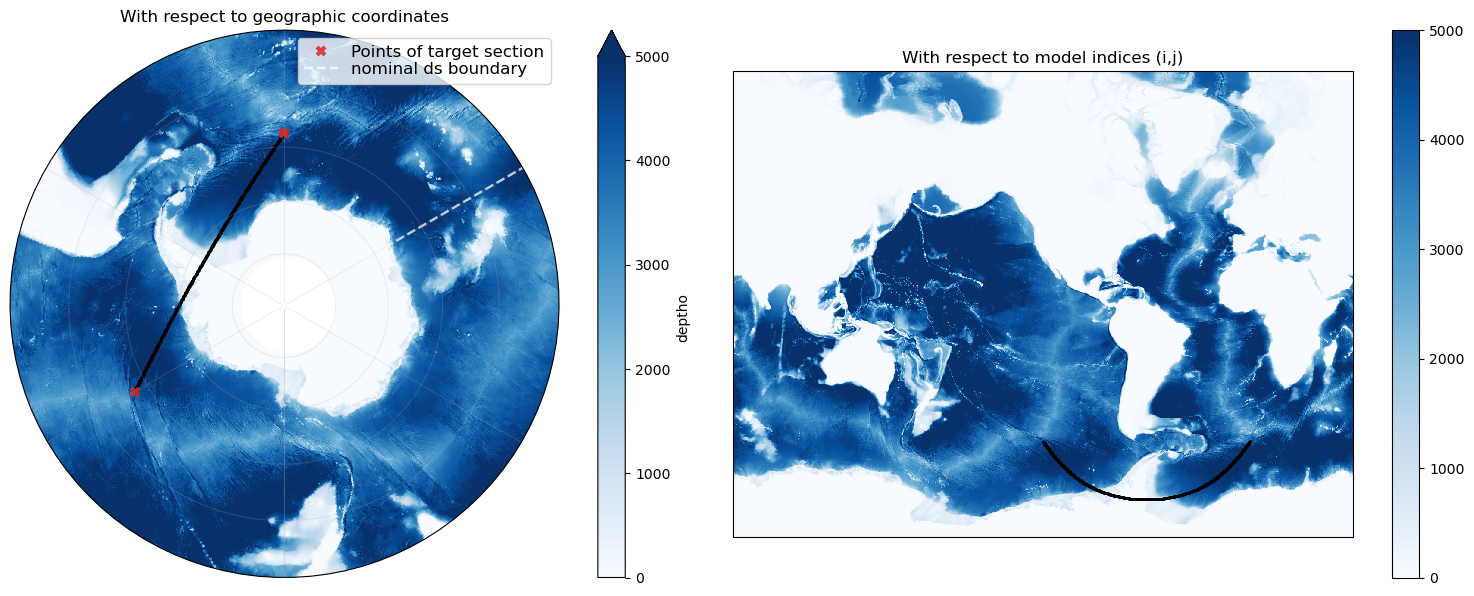

In [11]:
section_lons=[0, 240, 360]
section_lats=[lat]*len(section_lons)

i, j, lons, lats = sectionate.grid_section(
    grid,
    section_lons,
    section_lats,
    topology="MOM-tripolar"
)
plot_sections(i, j, lons, lats, section_lons, section_lats, ds, projection=ccrs.SouthPolarStereo());

##### Correct use: series of intermediate points less than 180º apart 

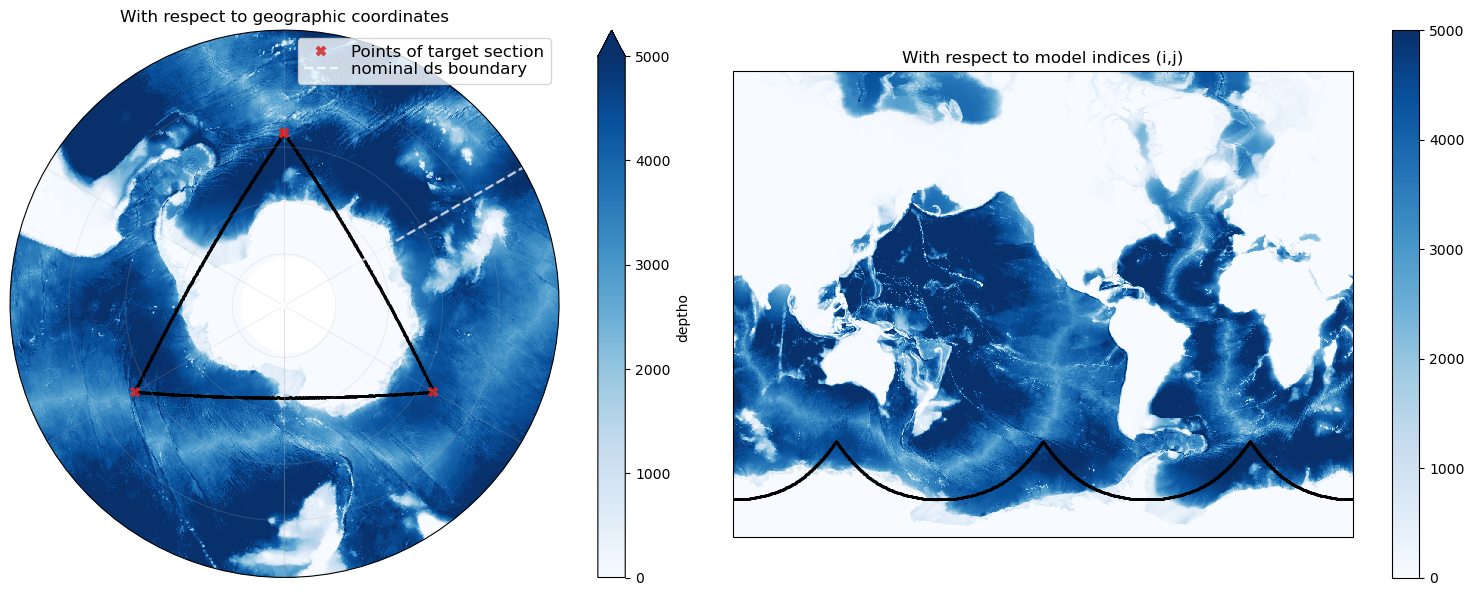

In [12]:
dlon=120
section_lons=np.arange(0., 360.+dlon, dlon)
section_lats=[lat]*len(section_lons)

i, j, lons, lats = sectionate.grid_section(
    grid,
    section_lons,
    section_lats,
    topology="MOM-tripolar"
)

plot_sections(i, j, lons, lats, section_lons, section_lats, ds, projection=ccrs.SouthPolarStereo());

To make strictly zonal sections, simply stitch together many great circle arcs:

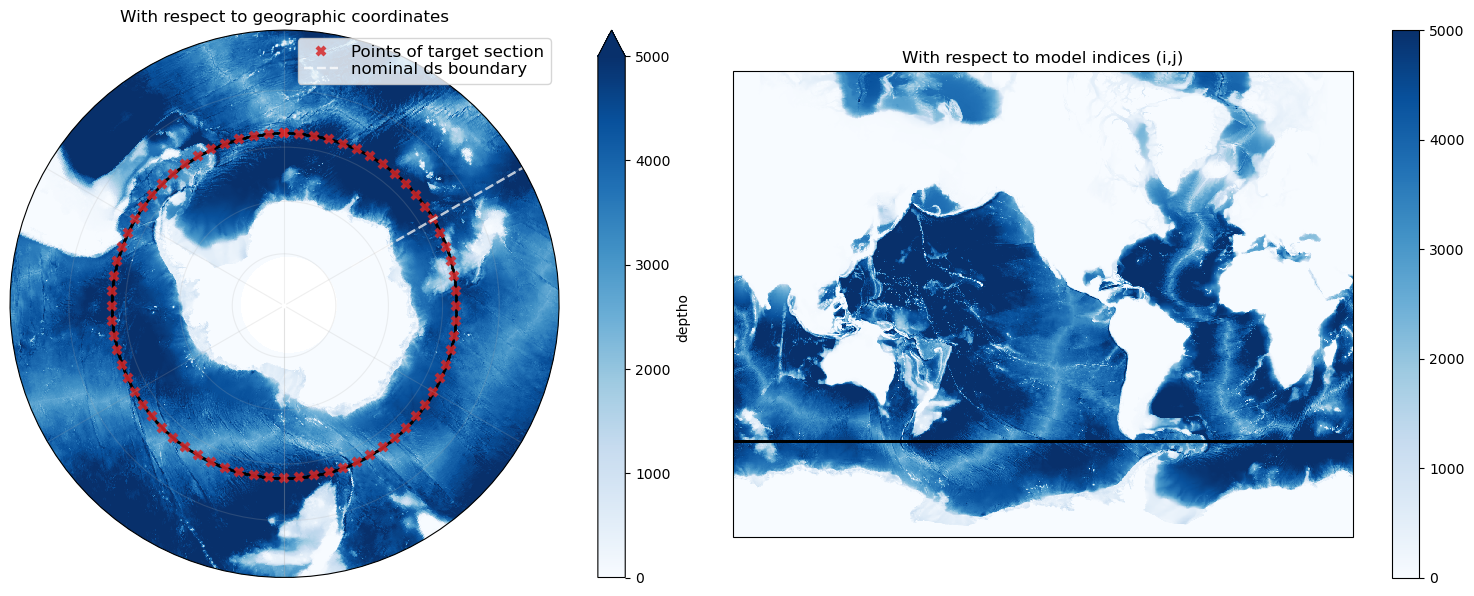

In [13]:
dlon=5
section_lons=np.arange(0., 360.+dlon, dlon)
section_lats=[lat]*len(section_lons)

i, j, lons, lats = sectionate.grid_section(
    grid,
    section_lons,
    section_lats,
    topology="MOM-tripolar"
)
plot_sections(i, j, lons, lats, section_lons, section_lats, ds, projection=ccrs.SouthPolarStereo());

## 3. Example of a complex section that crosses the boundary multiple times

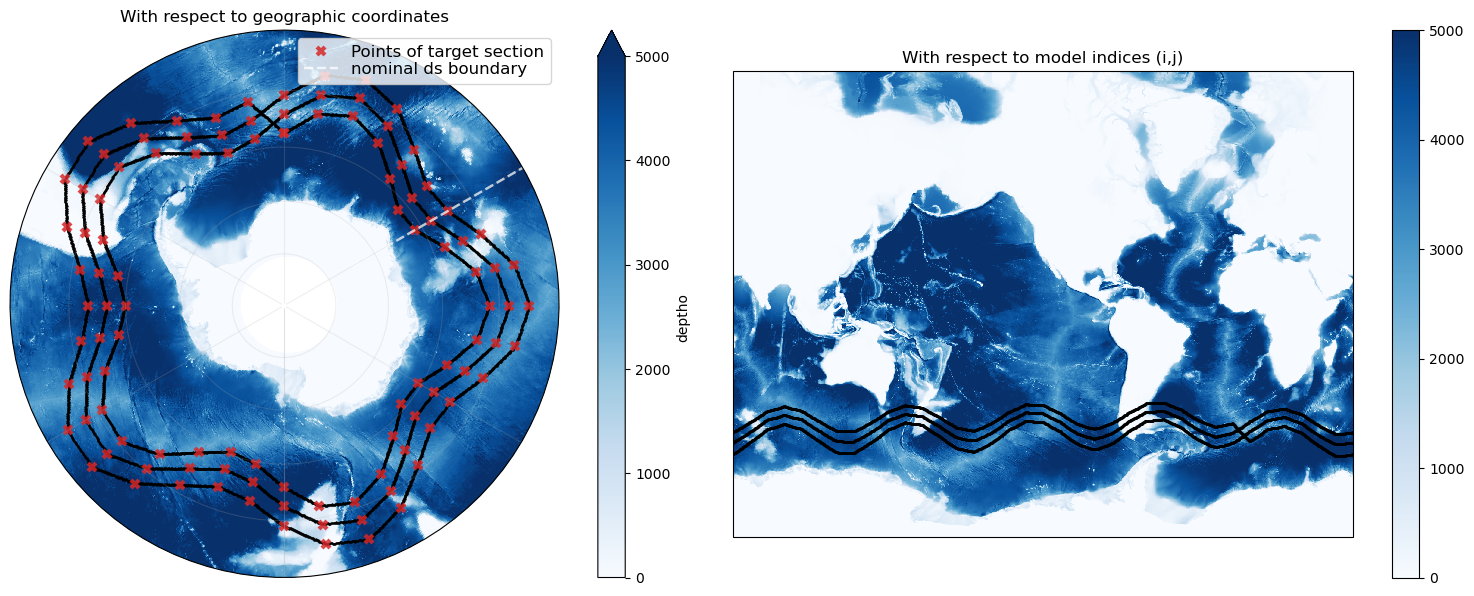

In [14]:
section_lons= np.arange(0, 360*3, 10.)
section_lats= lat + section_lons*(10/3.)/360. + 5*np.sin(5* (2*np.pi*section_lons/360.))

section_lons = np.append(section_lons, section_lons[0])
section_lats = np.append(section_lats, section_lats[0])

i, j, lons, lats = sectionate.grid_section(
    grid,
    section_lons,
    section_lats,
    topology="MOM-tripolar"
)
plot_sections(i, j, lons, lats, section_lons, section_lats, ds, projection=ccrs.SouthPolarStereo());

## 4. Verify that sections work correctly near and across MOM6's tripolar grid seams

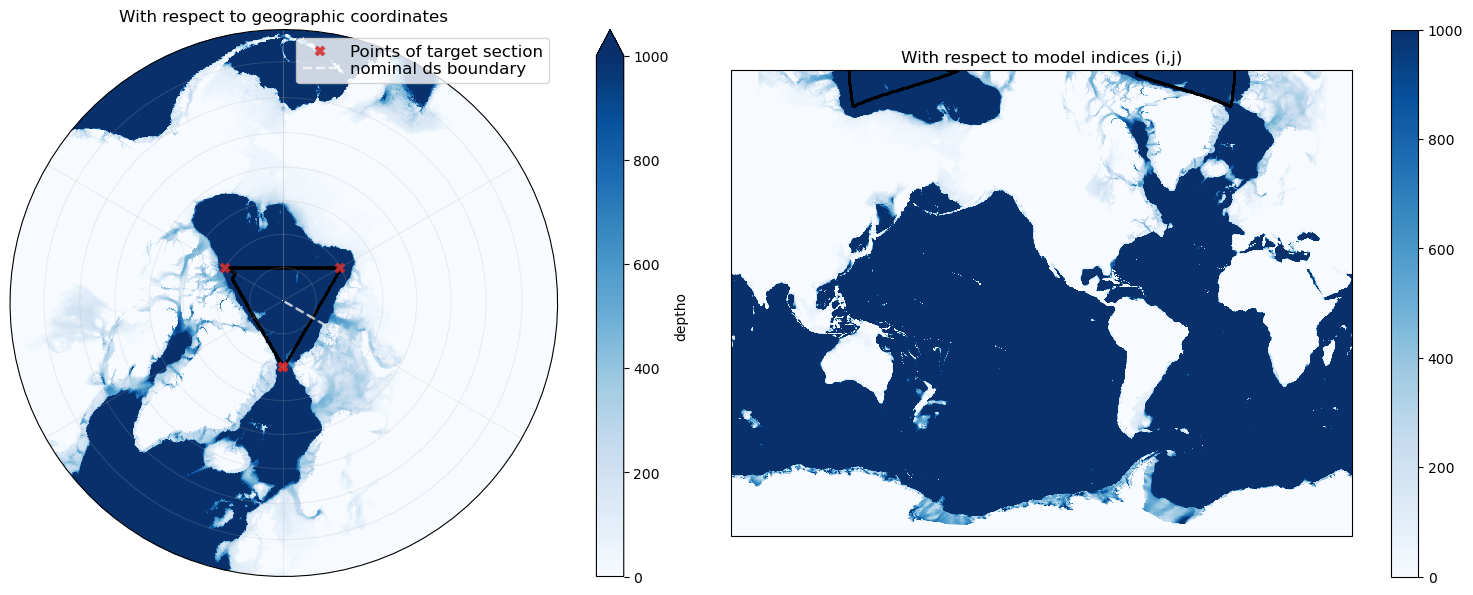

In [15]:
section_lons=[0, 120, 240, 360]
section_lats=[80]*len(section_lons)

i, j, lons, lats = sectionate.grid_section(
    grid,
    section_lons,
    section_lats,
    topology="MOM-tripolar"
)
plot_sections(i, j, lons, lats, section_lons, section_lats, ds, projection=ccrs.NorthPolarStereo(), vlim=[0, 1000]);

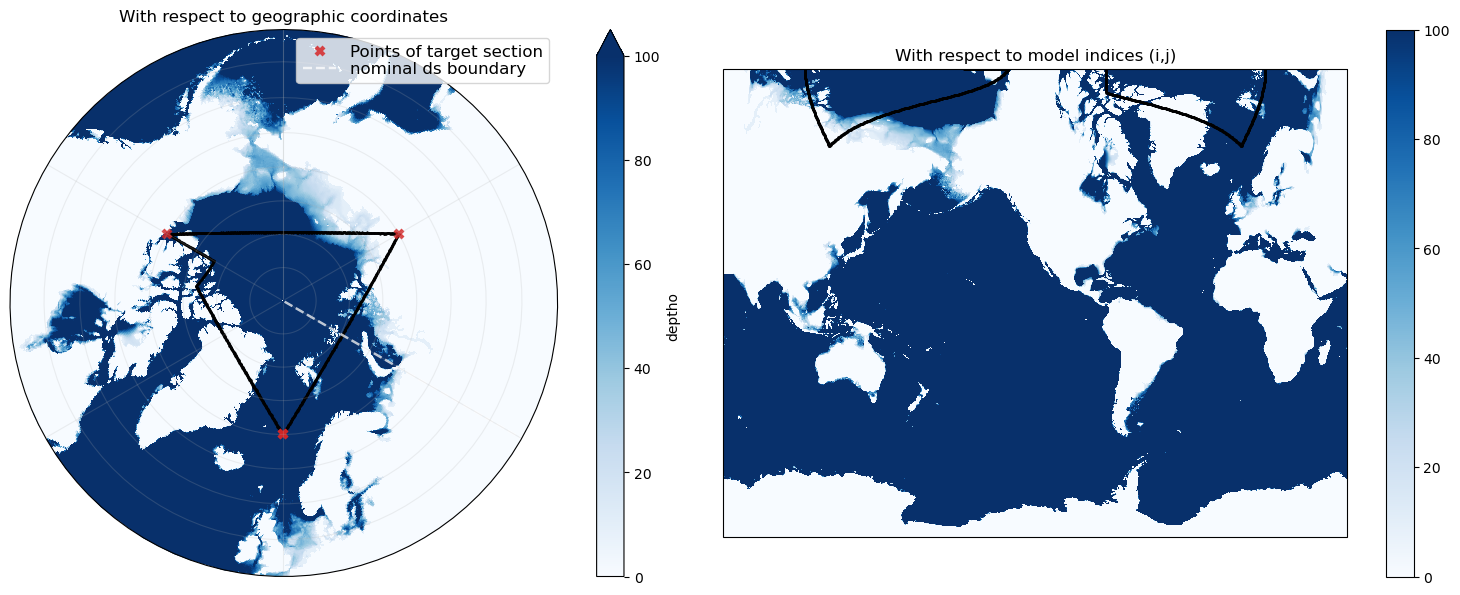

In [16]:
section_lons=[0, 120, 240, 360]
section_lats=[70]*len(section_lons)

i, j, lons, lats = sectionate.grid_section(
    grid,
    section_lons,
    section_lats,
    topology="MOM-tripolar"
)
plot_sections(i, j, lons, lats, section_lons, section_lats, ds, projection=ccrs.NorthPolarStereo(), vlim=[0, 100]);

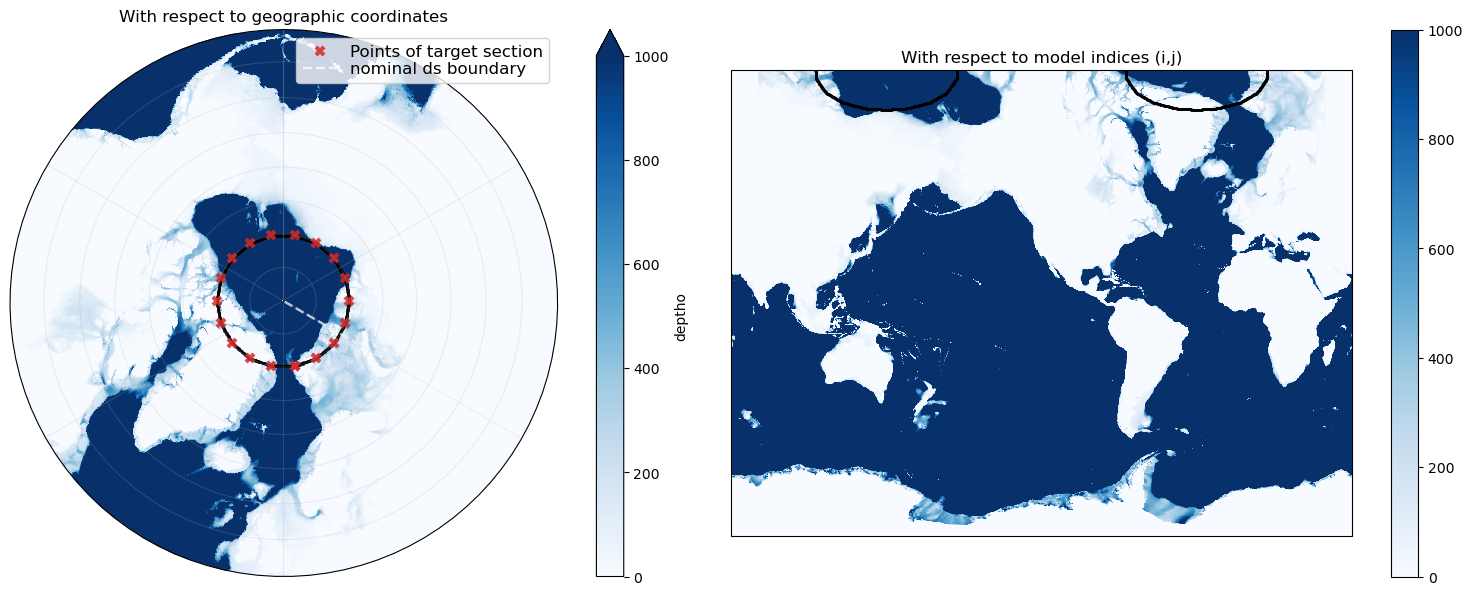

In [17]:
dlon = 20.
section_lons=np.arange(dlon/2, 360.+dlon, dlon)
section_lats=[80]*len(section_lons)

i, j, lons, lats = sectionate.grid_section(
    grid,
    section_lons,
    section_lats,
    topology="MOM-tripolar"
)
plot_sections(i, j, lons, lats, section_lons, section_lats, ds, projection=ccrs.NorthPolarStereo(), vlim=[0, 1000]);

##### Caution: sectionate has some difficulty when dealing with paths that traverse through the tripolar seams, apparently because it has to temporarily move backwards (go farther away from the target point) in order to make forward progress.

It is possible that there is a workaround, and that I just have not found it yet.

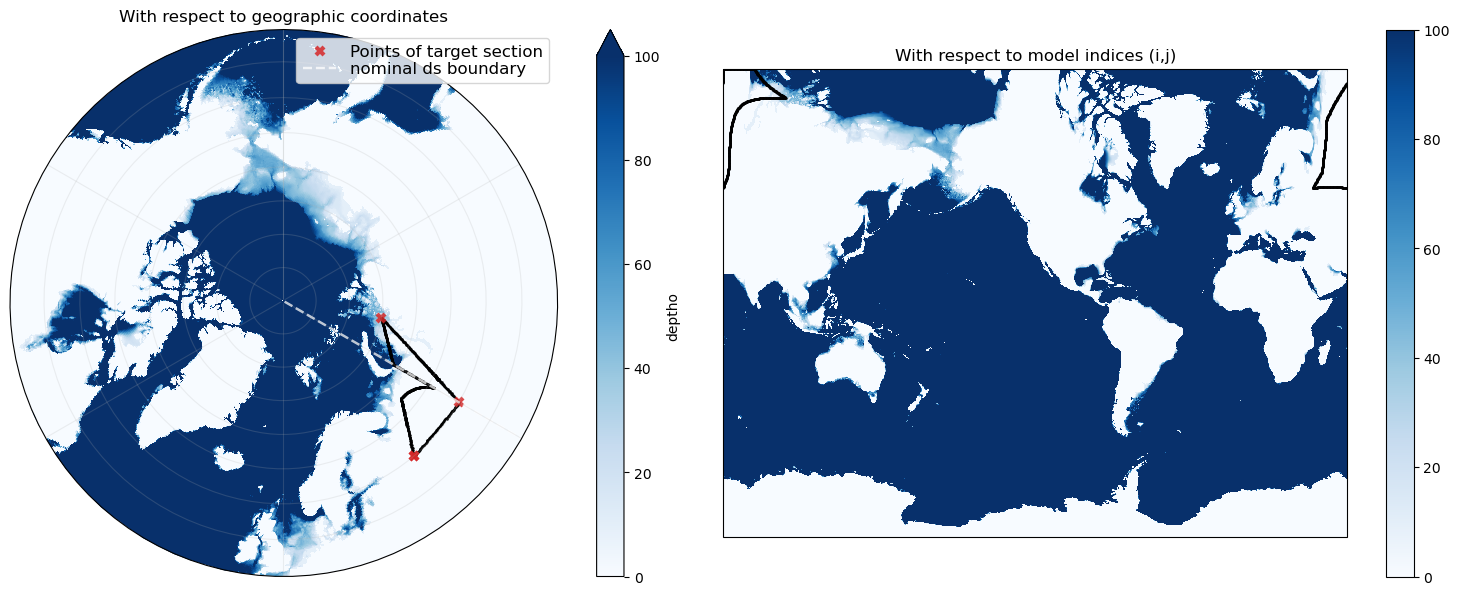

In [18]:
section_lons=[40, 60, 80., 40]
section_lats=[60, 60, 75, 60]

i, j, lons, lats = sectionate.grid_section(
    grid,
    section_lons,
    section_lats,
    topology="MOM-tripolar"
)
plot_sections(i, j, lons, lats, section_lons, section_lats, ds, projection=ccrs.NorthPolarStereo(), vlim=[0, 100]);